In [1]:
# --- Module Importing ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
import numpy as np
warnings.filterwarnings("ignore")

print("All necessary modules imported successfully.")

All necessary modules imported successfully.


# --- 1. Data Import and Basic Overview ---

In [2]:
data = pd.read_csv("CloudWatch_Traffic_Web_Attack (1).csv")
print(f"\nDataset loaded successfully from '{data}'.")


Dataset loaded successfully from '     bytes_in  bytes_out         creation_time              end_time  \
0        5602      12990  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
1       30912      18186  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
2       28506      13468  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
3       30546      14278  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
4        6526      13892  2024-04-25T23:00:00Z  2024-04-25T23:10:00Z   
..        ...        ...                   ...                   ...   
277     41336      13180  2024-04-26T09:50:00Z  2024-04-26T10:00:00Z   
278      3638       3190  2024-04-26T09:50:00Z  2024-04-26T10:00:00Z   
279  25207794    1561220  2024-04-26T09:50:00Z  2024-04-26T10:00:00Z   
280      5736      12114  2024-04-26T09:50:00Z  2024-04-26T10:00:00Z   
281      9032       5862  2024-04-26T09:50:00Z  2024-04-26T10:00:00Z   

              src_ip src_ip_country_code protocol  response.code  dst_port  \
0     147.161.161.82  

# --- 2. Data Preprocessing & Data Cleaning ---


In [3]:
df_unique = data.drop_duplicates().copy()
print(f"Number of rows after removing duplicates: {len(df_unique)}")

Number of rows after removing duplicates: 282


In [4]:
df_unique['creation_time'] = pd.to_datetime(df_unique['creation_time'], utc=True)
df_unique['end_time'] = pd.to_datetime(df_unique['end_time'], utc=True)
df_unique['time'] = pd.to_datetime(df_unique['time'], utc=True)
print("Converted 'creation_time', 'end_time', and 'time' columns to datetime format.")

Converted 'creation_time', 'end_time', and 'time' columns to datetime format.


# ---3.Standardization.---

In [5]:
df_unique['src_ip_country_code'] = df_unique['src_ip_country_code'].str.upper()
print("Standardized 'src_ip_country_code' to uppercase.")

print("\nUnique Datasets Information after cleaning (df_unique.info()):")
df_unique.info()
print("\nFirst 5 rows of the cleaned dataset (df_unique.head()):")
print(df_unique.head())

Standardized 'src_ip_country_code' to uppercase.

Unique Datasets Information after cleaning (df_unique.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null

# --- 4. Feature Engineering (continued from preprocessing) ---

In [6]:
df_unique['duration_seconds'] = (df_unique['end_time'] - df_unique['creation_time']).dt.total_seconds()
print("Calculated 'duration_seconds' feature.")

Calculated 'duration_seconds' feature.


In [7]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_unique[['bytes_in', 'bytes_out', 'duration_seconds']])
print("Scaled 'bytes_in', 'bytes_out', and 'duration_seconds' using StandardScaler.")

Scaled 'bytes_in', 'bytes_out', and 'duration_seconds' using StandardScaler.


In [8]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df_unique[['src_ip_country_code']])
print("One-hot encoded 'src_ip_country_code'.")

One-hot encoded 'src_ip_country_code'.


In [9]:
scaled_columns = ['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration_seconds']
encoded_columns = encoder.get_feature_names_out(['src_ip_country_code'])

In [10]:
scaled_df = pd.DataFrame(scaled_features, columns=scaled_columns, index=df_unique.index)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=df_unique.index)

In [11]:
transformed_df = pd.concat([df_unique, scaled_df, encoded_df], axis=1)
print("Combined original, scaled, and encoded features into 'transformed_df'.")

Combined original, scaled, and encoded features into 'transformed_df'.


In [12]:
print("\nFirst 5 rows of the transformed dataset (transformed_df.head()):")
print(transformed_df.head())


First 5 rows of the transformed dataset (transformed_df.head()):
   bytes_in  bytes_out             creation_time                  end_time  \
0      5602      12990 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
1     30912      18186 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
2     28506      13468 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
3     30546      14278 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   
4      6526      13892 2024-04-25 23:00:00+00:00 2024-04-25 23:10:00+00:00   

            src_ip src_ip_country_code protocol  response.code  dst_port  \
0   147.161.161.82                  AE    HTTPS            200       443   
1     165.225.33.6                  US    HTTPS            200       443   
2  165.225.212.255                  CA    HTTPS            200       443   
3   136.226.64.114                  US    HTTPS            200       443   
4   165.225.240.79                  NL    HTTPS            200       443   

        

# --- 3. Exploratory Data Analysis (EDA) - Statistical Analysis and Visualizations ---

In [13]:
df_for_eda = df_unique.copy()


--- Analyzing Traffic Patterns Based on bytes_in and bytes_out ---


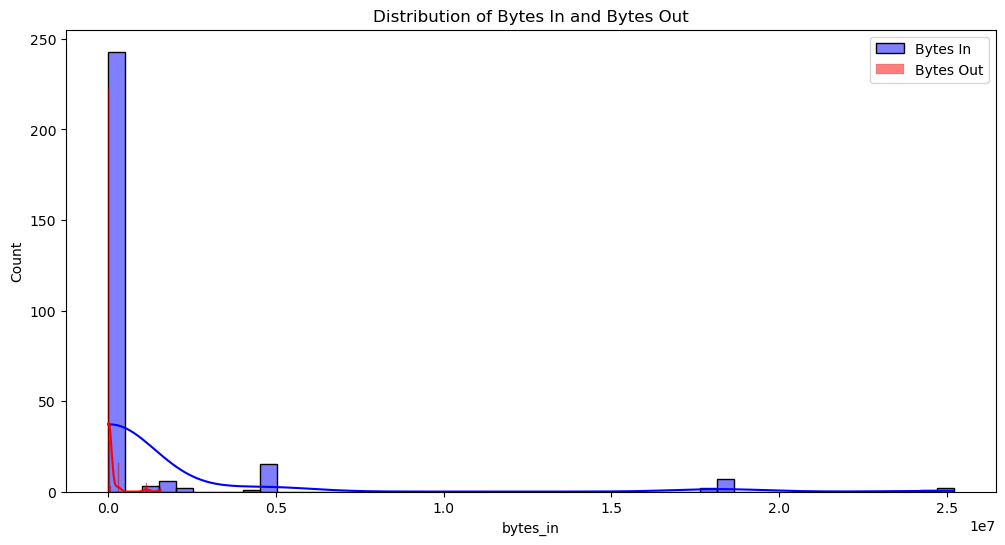

In [14]:
print("\n--- Analyzing Traffic Patterns Based on bytes_in and bytes_out ---")
plt.figure(figsize=(12,6))
sns.histplot(df_for_eda['bytes_in'], bins=50, color='blue', kde=True, label='Bytes In')
sns.histplot(df_for_eda['bytes_out'], bins=50, color='red', kde=True, label='Bytes Out')
plt.legend()
plt.title('Distribution of Bytes In and Bytes Out')
plt.show()


--- Count of Protocols Used ---


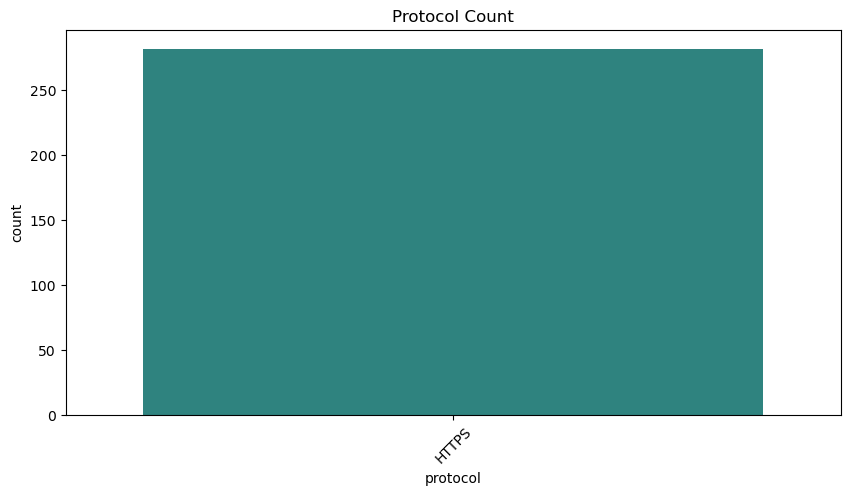

In [15]:
print("\n--- Count of Protocols Used ---")
plt.figure(figsize=(10,5))
sns.countplot(x='protocol', data=df_for_eda, palette='viridis')
plt.title('Protocol Count')
plt.xticks(rotation=45)
plt.show()

In [16]:
print("\n--- Descriptive Statistics ---")
print("Descriptive statistics for numerical features:")
print(transformed_df.select_dtypes(include=['float64', 'int64']).describe())


--- Descriptive Statistics ---
Descriptive statistics for numerical features:
           bytes_in     bytes_out  response.code  dst_port  duration_seconds  \
count  2.820000e+02  2.820000e+02          282.0     282.0             282.0   
mean   1.199390e+06  8.455429e+04          200.0     443.0             600.0   
std    4.149312e+06  2.549279e+05            0.0       0.0               0.0   
min    4.000000e+01  4.400000e+01          200.0     443.0             600.0   
25%    5.381500e+03  1.114200e+04          200.0     443.0             600.0   
50%    1.318200e+04  1.379950e+04          200.0     443.0             600.0   
75%    3.083300e+04  2.627950e+04          200.0     443.0             600.0   
max    2.520779e+07  1.561220e+06          200.0     443.0             600.0   

       scaled_bytes_in  scaled_bytes_out  scaled_duration_seconds  \
count     2.820000e+02      2.820000e+02                    282.0   
mean     -1.259828e-17     -1.259828e-17                      

In [17]:
print("\n--- Correlation Analysis ---")
numeric_df_transformed = transformed_df.select_dtypes(include=['float64', 'int64'])
correlation_matrix_numeric = numeric_df_transformed.corr()
print("\nCorrelation Matrix (numeric features):\n", correlation_matrix_numeric)


--- Correlation Analysis ---

Correlation Matrix (numeric features):
                          bytes_in  bytes_out  response.code  dst_port  \
bytes_in                 1.000000   0.997705            NaN       NaN   
bytes_out                0.997705   1.000000            NaN       NaN   
response.code                 NaN        NaN            NaN       NaN   
dst_port                      NaN        NaN            NaN       NaN   
duration_seconds              NaN        NaN            NaN       NaN   
scaled_bytes_in          1.000000   0.997705            NaN       NaN   
scaled_bytes_out         0.997705   1.000000            NaN       NaN   
scaled_duration_seconds       NaN        NaN            NaN       NaN   
src_ip_country_code_AE  -0.070559  -0.072452            NaN       NaN   
src_ip_country_code_AT  -0.081670  -0.081777            NaN       NaN   
src_ip_country_code_CA  -0.166488  -0.159587            NaN       NaN   
src_ip_country_code_DE  -0.095333  -0.090001         

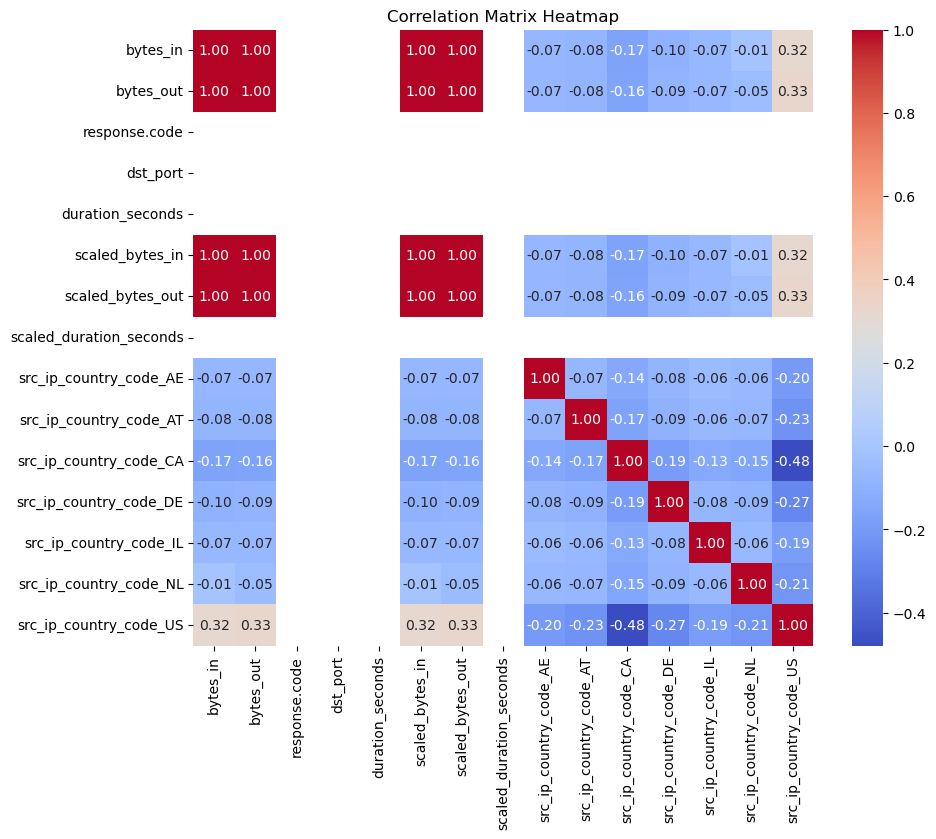

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix_numeric, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


--- Stacked Bar Chart for Detection Types by Country ---


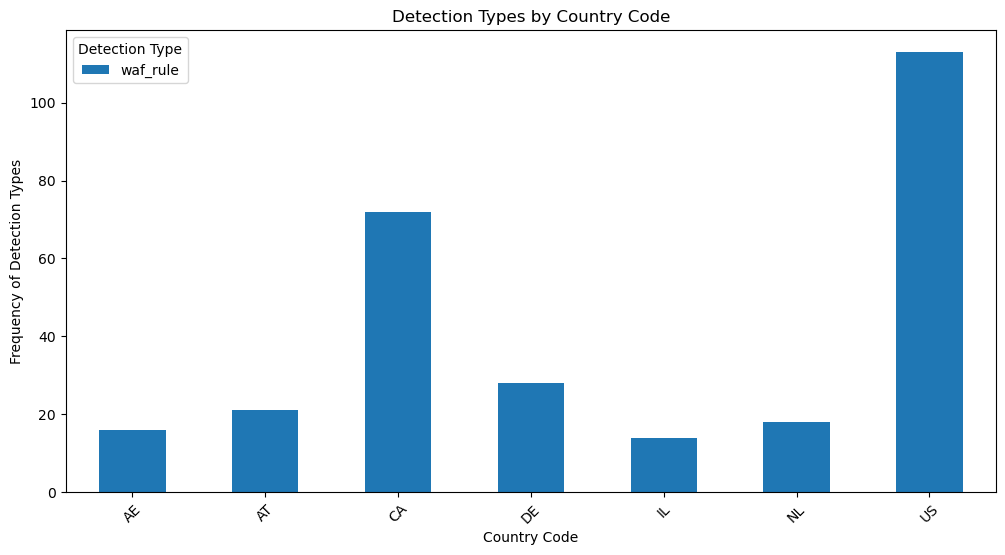

In [19]:
print("\n--- Stacked Bar Chart for Detection Types by Country ---")
detection_types_by_country = pd.crosstab(transformed_df['src_ip_country_code'],
                                         transformed_df['detection_types'])
detection_types_by_country.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Detection Types by Country Code')
plt.xlabel('Country Code')
plt.ylabel('Frequency of Detection Types')
plt.xticks(rotation=45)
plt.legend(title='Detection Type')
plt.show()

In [20]:
print("\n--- Web Traffic Analysis Over Time ---")
# Ensure 'data' has 'creation_time' as datetime before setting index
if not pd.api.types.is_datetime64_any_dtype(data['creation_time']):
    data['creation_time'] = pd.to_datetime(data['creation_time'], utc=True)
data_indexed = data.set_index('creation_time').copy()
print("Set 'creation_time' as index for time series analysis.")


--- Web Traffic Analysis Over Time ---
Set 'creation_time' as index for time series analysis.


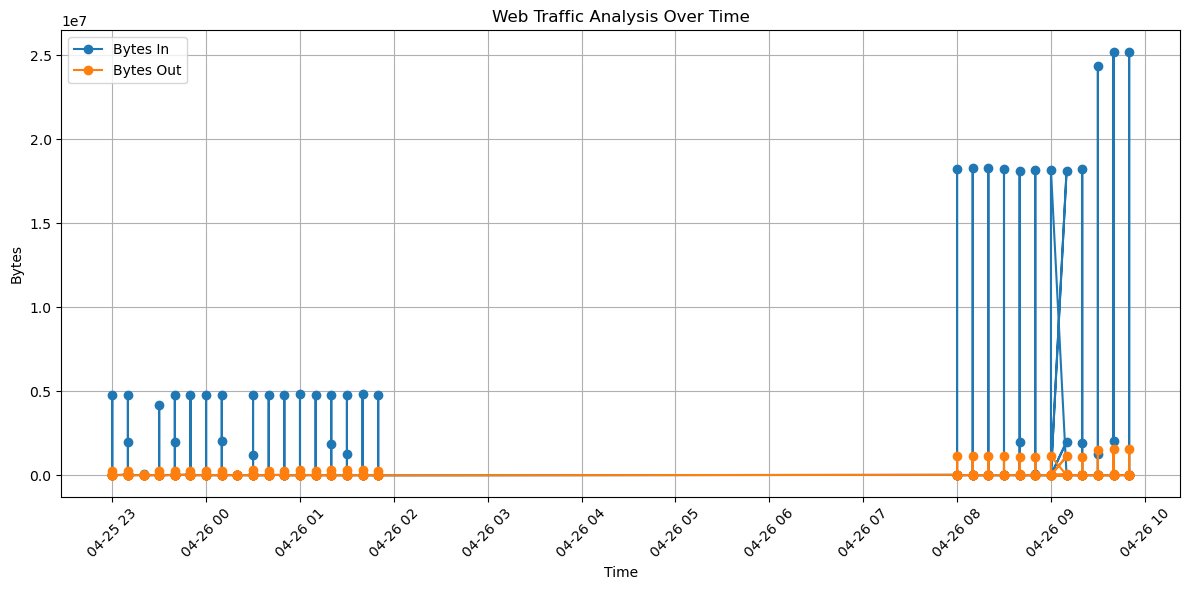

In [21]:
plt.figure(figsize=(12,6))
plt.plot(data_indexed.index, data_indexed['bytes_in'], label='Bytes In', marker='o')
plt.plot(data_indexed.index, data_indexed['bytes_out'], label='Bytes Out', marker='o')
plt.title('Web Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


--- Network Interaction between Source and Destination IPs ---


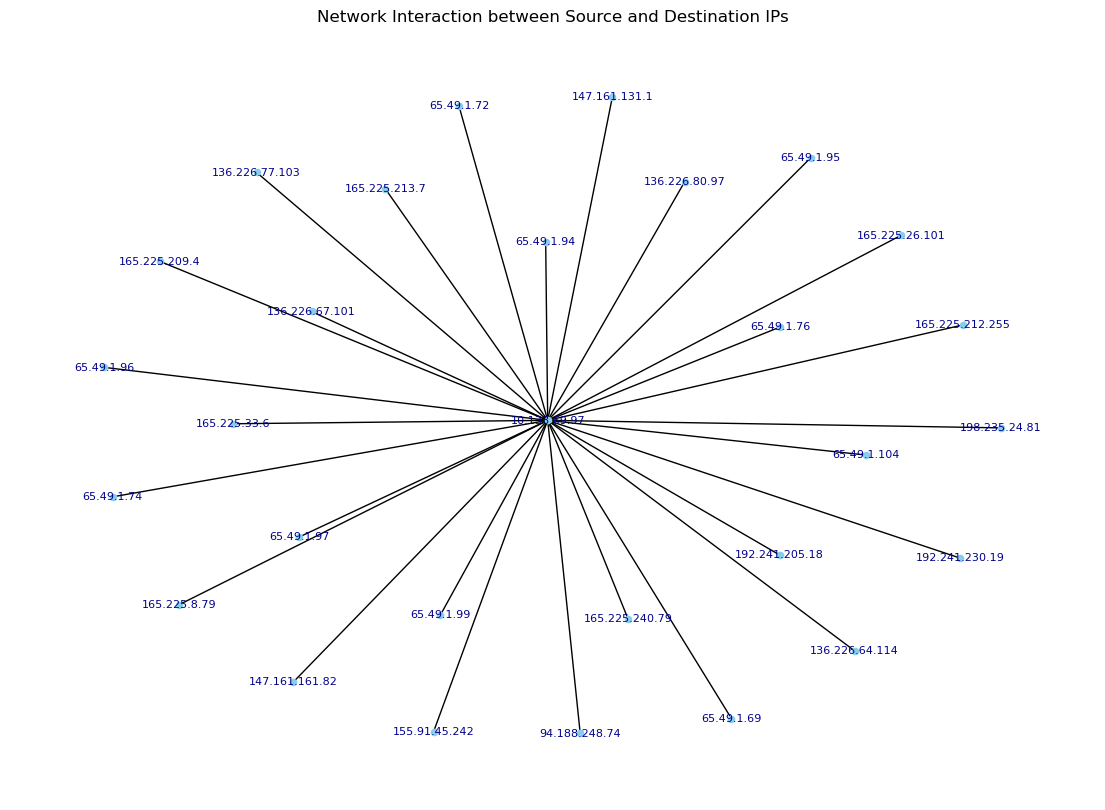

In [22]:
print("\n--- Network Interaction between Source and Destination IPs ---")
G = nx.Graph()
for idx, row in data.iterrows():
    G.add_edge(row['src_ip'], row['dst_ip'])

plt.figure(figsize=(14,10))
nx.draw_networkx(G, with_labels=True, node_size=20, font_size=8, node_color='skyblue', font_color='darkblue')
plt.title('Network Interaction between Source and Destination IPs')
plt.axis('off')
plt.show()

# --- 6. Modeling: Anomaly Detection (Isolation Forest) ---


In [23]:
# Ensure 'session_duration' is available in 'df_unique'
if 'session_duration' not in df_unique.columns:
    df_unique['session_duration'] = (df_unique['end_time'] - df_unique['creation_time']).dt.total_seconds()
    print("Added 'session_duration' to df_unique for Isolation Forest if not already present.")

# For avg_packet_size, ensure it's calculated or derive it
if 'avg_packet_size' not in df_unique.columns:
    # Check if 'session_duration' is not zero to avoid division by zero. Replace 0 with NaN for safety.
    df_unique['avg_packet_size'] = (df_unique['bytes_in'] + df_unique['bytes_out']) / df_unique['session_duration'].replace(0, np.nan)
    df_unique['avg_packet_size'].fillna(0, inplace=True) # Fill NaN (from division by zero) with 0 or a suitable value
    print("Added 'avg_packet_size' to df_unique for Isolation Forest if not already present.")

Added 'session_duration' to df_unique for Isolation Forest if not already present.
Added 'avg_packet_size' to df_unique for Isolation Forest if not already present.


In [24]:
features_anomaly = df_unique[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]

model_iso = IsolationForest(contamination=0.05, random_state=42)
print("Initialized Isolation Forest model.")

Initialized Isolation Forest model.


In [25]:
df_unique['anomaly'] = model_iso.fit_predict(features_anomaly)
df_unique['anomaly'] = df_unique['anomaly'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')
print("Isolation Forest model fitted and anomalies predicted.")

Isolation Forest model fitted and anomalies predicted.


# --- 7. Evaluation (Isolation Forest) ---

In [26]:
print("\n--- Evaluating Anomaly Detection (Isolation Forest) ---")
print("Proportion of anomalies detected:")
print(df_unique['anomaly'].value_counts())
print("\nFirst 5 suspicious activities detected by Isolation Forest:")
suspicious_activities_iso = df_unique[df_unique['anomaly'] == 'Suspicious']
print(suspicious_activities_iso.head())


--- Evaluating Anomaly Detection (Isolation Forest) ---
Proportion of anomalies detected:
anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64

First 5 suspicious activities detected by Isolation Forest:
     bytes_in  bytes_out             creation_time                  end_time  \
36    4190330     283456 2024-04-25 23:30:00+00:00 2024-04-25 23:40:00+00:00   
87    1215594      64362 2024-04-26 00:30:00+00:00 2024-04-26 00:40:00+00:00   
116   4827283     306181 2024-04-26 01:00:00+00:00 2024-04-26 01:10:00+00:00   
132   1889834      34306 2024-04-26 01:20:00+00:00 2024-04-26 01:30:00+00:00   
153   4869181     301752 2024-04-26 01:40:00+00:00 2024-04-26 01:50:00+00:00   

             src_ip src_ip_country_code protocol  response.code  dst_port  \
36    155.91.45.242                  US    HTTPS            200       443   
87   165.225.240.79                  NL    HTTPS            200       443   
116   155.91.45.242                  US    HTTPS            200   

# --- 8. Visualization of Anomalies (Isolation Forest) ---


--- Visualizing Anomalies (Isolation Forest) ---


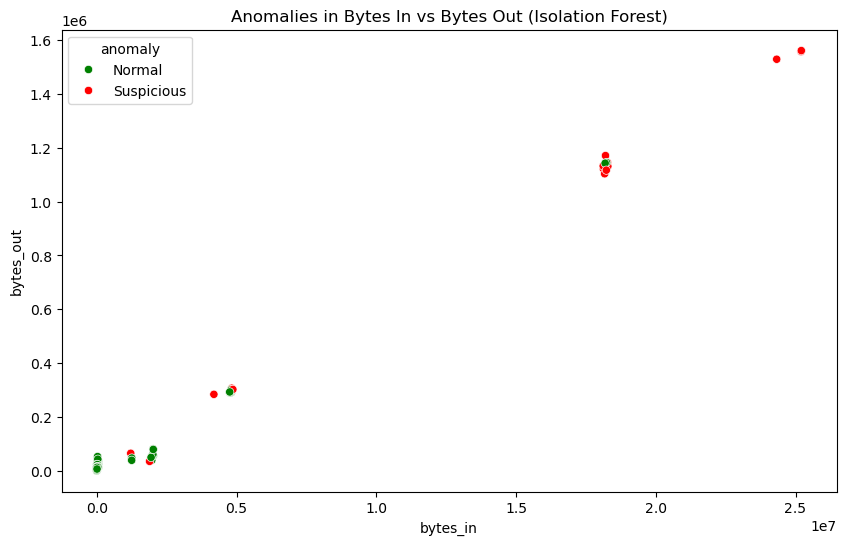

In [27]:
print("\n--- Visualizing Anomalies (Isolation Forest) ---")
plt.figure(figsize=(10,6))
sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', data=df_unique, palette=['green', 'red'])
plt.title('Anomalies in Bytes In vs Bytes Out (Isolation Forest)')
plt.show()

# --- Random Forest Classifier ---

In [28]:
print("\n--- Starting Random Forest Classifier ---")

transformed_df['is_suspicious'] = (transformed_df['detection_types'] == 'waf_rule').astype(int)
print("Encoded 'detection_types' to 'is_suspicious' binary labels.")


--- Starting Random Forest Classifier ---
Encoded 'detection_types' to 'is_suspicious' binary labels.


In [29]:
X_rf = transformed_df[['bytes_in', 'bytes_out', 'scaled_duration_seconds']]
y_rf = transformed_df['is_suspicious']

In [30]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)
print("Split data into training and testing sets for Random Forest Classifier.")

Split data into training and testing sets for Random Forest Classifier.


In [31]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
print("Initialized Random Forest Classifier.")

Initialized Random Forest Classifier.


In [32]:
rf_classifier.fit(X_train_rf, y_train_rf)
print("Random Forest Classifier trained.")

Random Forest Classifier trained.


In [33]:
y_pred_rf = rf_classifier.predict(X_test_rf)
print("Predictions made on the test set.")

Predictions made on the test set.


In [34]:
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
classification_rf = classification_report(y_test_rf, y_pred_rf)
print("\nRandom Forest Classifier Model Accuracy: ", accuracy_rf)
print("Random Forest Classifier Classification Report:\n", classification_rf)


Random Forest Classifier Model Accuracy:  1.0
Random Forest Classifier Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



In [35]:
# --- Neural Network (Simple Dense Layers) ---
print("\n--- Starting Neural Network (Simple Dense Layers) ---")


--- Starting Neural Network (Simple Dense Layers) ---


In [36]:
if 'is_suspicious' not in data.columns:
    data['is_suspicious'] = (data['detection_types'] == 'waf_rule').astype(int)

X_nn = data[['bytes_in', 'bytes_out']].values
y_nn = data['is_suspicious'].values
print("Prepared features and labels for Neural Network.")

Prepared features and labels for Neural Network.


In [37]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_nn, y_nn, test_size=0.3, random_state=42)
print("Split data into training and testing sets for Neural Network.")

Split data into training and testing sets for Neural Network.


In [38]:
scaler_nn = StandardScaler()
X_train_scaled_nn = scaler_nn.fit_transform(X_train_nn)
X_test_scaled_nn = scaler_nn.transform(X_test_nn)
print("Normalized features for Neural Network.")

Normalized features for Neural Network.


In [39]:
model_nn_simple = Sequential([
    Dense(8, activation='relu', input_shape=(X_train_scaled_nn.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
print("Defined simple Neural Network model.")

Defined simple Neural Network model.


In [40]:
model_nn_simple.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
print("Compiled Neural Network model.")

Compiled Neural Network model.


In [41]:
history_nn_simple = model_nn_simple.fit(X_train_scaled_nn, y_train_nn, epochs=10, batch_size=8, verbose=1)
print("Neural Network model trained.")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 1.0000 - loss: 0.6401
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.5696
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.5012
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.4063
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.3154
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.2125
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.1261
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0734
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0430
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0239
Neural Network model trained.


In [42]:
loss_nn_simple, accuracy_nn_simple = model_nn_simple.evaluate(X_test_scaled_nn, y_test_nn)
print(f"Simple Neural Network Test Accuracy: {accuracy_nn_simple*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0187 
Simple Neural Network Test Accuracy: 100.00%


In [43]:
# --- Neural Network (with Dropout Layers) ---
print("\n--- Starting Neural Network (with Dropout Layers) ---")

model_nn_dropout = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled_nn.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
print("Defined Neural Network model with Dropout layers.")


--- Starting Neural Network (with Dropout Layers) ---
Defined Neural Network model with Dropout layers.


In [44]:
model_nn_dropout.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
print("Compiled Neural Network model with Dropout.")

Compiled Neural Network model with Dropout.


In [45]:
history_nn_dropout = model_nn_dropout.fit(X_train_scaled_nn, y_train_nn, epochs=10, batch_size=32, verbose=1, validation_split=0.2)
print("Neural Network model with Dropout trained.")

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.7330 - loss: 0.6797 - val_accuracy: 1.0000 - val_loss: 0.5757
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.5849 - val_accuracy: 1.0000 - val_loss: 0.5032
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.5273 - val_accuracy: 1.0000 - val_loss: 0.4260
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.4411 - val_accuracy: 1.0000 - val_loss: 0.3467
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.3537 - val_accuracy: 1.0000 - val_loss: 0.2658
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.2725 - val_accuracy: 1.0000 - val_loss: 0.1892
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.2018 - val_accuracy: 1.0000 - val_loss: 0.1253
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.1324 - val_accuracy: 1.0000 - val_loss: 0.0784

In [46]:
loss_nn_dropout, accuracy_nn_dropout = model_nn_dropout.evaluate(X_test_scaled_nn, y_test_nn)
print(f"Neural Network with Dropout Test Accuracy: {accuracy_nn_dropout*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0337
Neural Network with Dropout Test Accuracy: 100.00%


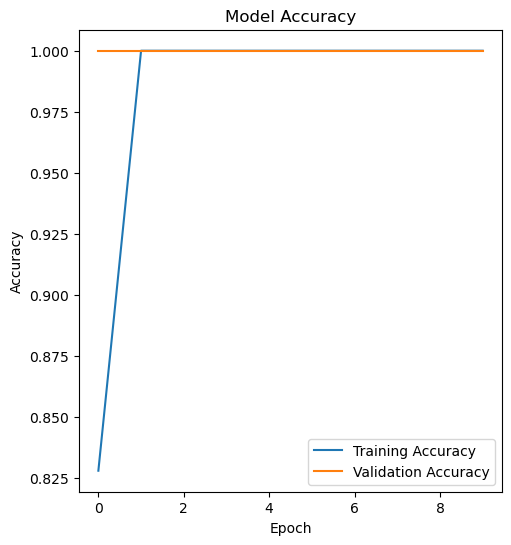

In [47]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history_nn_dropout.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history_nn_dropout.history:
    plt.plot(history_nn_dropout.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

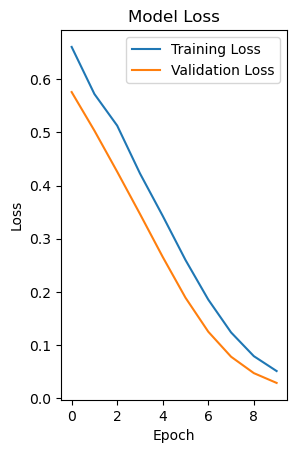

In [48]:
plt.subplot(1, 2, 2)
plt.plot(history_nn_dropout.history['loss'], label='Training Loss')
if 'val_loss' in history_nn_dropout.history:
    plt.plot(history_nn_dropout.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# --- Neural Network (Conv1D) ---

In [49]:
print("\n--- Starting Neural Network (Conv1D) ---")

X_train_scaled_conv = X_train_scaled_nn.reshape(X_train_scaled_nn.shape[0], X_train_scaled_nn.shape[1], 1)
X_test_scaled_conv = X_test_scaled_nn.reshape(X_test_scaled_nn.shape[0], X_test_scaled_nn.shape[1], 1)
print(f"Reshaped data for Conv1D: X_train_scaled_conv shape {X_train_scaled_conv.shape}, X_test_scaled_conv shape {X_test_scaled_conv.shape}.")

model_conv1d = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(X_train_scaled_conv.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
print("Defined Conv1D Neural Network model.")


--- Starting Neural Network (Conv1D) ---
Reshaped data for Conv1D: X_train_scaled_conv shape (197, 2, 1), X_test_scaled_conv shape (85, 2, 1).
Defined Conv1D Neural Network model.


In [50]:
model_conv1d.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
print("Compiled Conv1D Neural Network model.")

Compiled Conv1D Neural Network model.


In [51]:
history_conv1d = model_conv1d.fit(X_train_scaled_conv, y_train_nn, epochs=10, batch_size=32, verbose=1, validation_split=0.2)
print("Conv1D Neural Network model trained.")

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.5741 - loss: 0.6832 - val_accuracy: 1.0000 - val_loss: 0.6197
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9585 - loss: 0.6383 - val_accuracy: 1.0000 - val_loss: 0.5800
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.6156 - val_accuracy: 1.0000 - val_loss: 0.5481
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.5862 - val_accuracy: 1.0000 - val_loss: 0.5169
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.5457 - val_accuracy: 1.0000 - val_loss: 0.4833
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.5169 - val_accuracy: 1.0000 - val_loss: 0.4463
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.4780 - val_accuracy: 1.0000 - val_loss: 0.4055
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.4280 - val_accuracy: 1.0000 - val_loss: 0.3611

In [52]:
loss_conv1d, accuracy_conv1d = model_conv1d.evaluate(X_test_scaled_conv, y_test_nn)
print(f"Conv1D Neural Network Test Accuracy: {accuracy_conv1d*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.2899
Conv1D Neural Network Test Accuracy: 100.00%


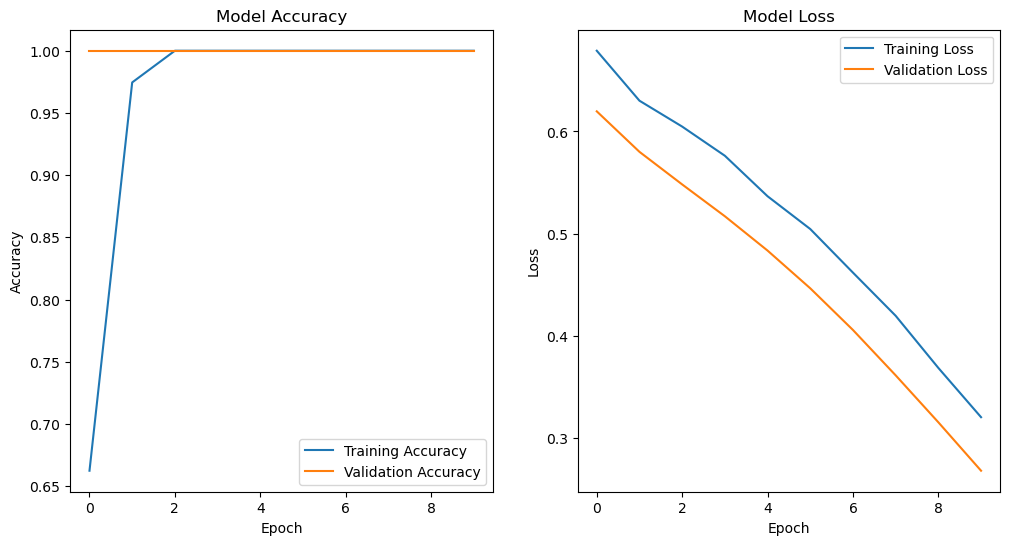

In [53]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history_conv1d.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history_conv1d.history:
    plt.plot(history_conv1d.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_conv1d.history['loss'], label='Training Loss')
if 'val_loss' in history_conv1d.history:
    plt.plot(history_conv1d.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
print("\n--- Project tasks completed successfully ---")


--- Project tasks completed successfully ---
